# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [13]:
import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

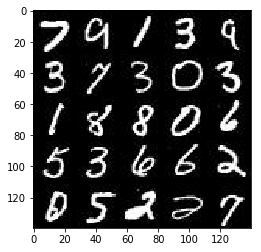

In [14]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

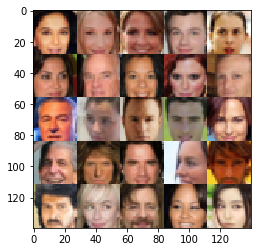

In [15]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [18]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name = 'input_z')
    lr = tf.placeholder(tf.float32,(None), name = 'learning_rate')
    
    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [21]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    alpha = 0.2
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse = reuse):
        
        # 14x14x64
        x1 = tf.layers.conv2d(inputs = images, filters = 64, kernel_size = 5, strides = 2, padding = 'same')
        x1 = tf.maximum(alpha * x1, x1)       #leaky relu
        
        # 7x7x128
        x2 = tf.layers.conv2d(inputs = x1, filters = 128, kernel_size = 5, strides = 2, padding = 'same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)       #leaky relu
        
        # 4x4x256
        x3 = tf.layers.conv2d(inputs = x2, filters = 256, kernel_size = 5, strides = 2, padding = 'same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)       #leaky relu
        
        # flatten it
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [23]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    if is_train:
        keep_prob = 1
    else:
        keep_prob = 0.8
        
    alpha = 0.2
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = not is_train):
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*256)
        # reshaping to start of convolutional stack
        # unflatten layer
        x1 = tf.reshape(x1, (-1, 4, 4, 256))
        x1 = tf.layers.batch_normalization(x1, training = is_train)
        x1 = tf.maximum(alpha * x1, x1)       #leaky relu
        x1 = tf.layers.dropout(x1,keep_prob)
        
        # 7X7x128
        x2 = tf.layers.conv2d_transpose(inputs=x1, filters=128, kernel_size=4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        x2 = tf.maximum(alpha * x2, x2)       #leaky relu
        x2 = tf.layers.dropout(x2,keep_prob)
        
        # 14x14x64
        x3 = tf.layers.conv2d_transpose(inputs=x2, filters=64, kernel_size=3, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training = is_train)
        x3 = tf.maximum(alpha * x3, x3)       #leaky relu
        x3 = tf.layers.dropout(x3,keep_prob)
        
        # Output layer, 28x28xout_channel_dim
        logits = tf.layers.conv2d_transpose(inputs=x3, filters=out_channel_dim, kernel_size=2, strides=2, padding='same')       
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [24]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [25]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_updates = [opt for opt in update_ops if opt.name.startswith('discriminator')]
    with tf.control_dependencies(d_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [26]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [27]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images = batch_images* 2
                # TODO: Train Model
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                 # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real : batch_images, input_z : batch_z})
                _ = sess.run(g_opt, feed_dict={input_z : batch_z})
            
                if steps % 10 == 0:
                    # At the end of each 10 epochs, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images, lr:learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z, lr:learning_rate})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:
                    # At the end of each 100 epochs, show generator output
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                               

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.6253... Generator Loss: 14.7221
Epoch 1/2... Discriminator Loss: 0.5708... Generator Loss: 2.6113
Epoch 1/2... Discriminator Loss: 1.1050... Generator Loss: 3.8960
Epoch 1/2... Discriminator Loss: 0.5731... Generator Loss: 3.6539
Epoch 1/2... Discriminator Loss: 0.6417... Generator Loss: 3.2101
Epoch 1/2... Discriminator Loss: 0.7109... Generator Loss: 2.1215
Epoch 1/2... Discriminator Loss: 0.6241... Generator Loss: 1.6646
Epoch 1/2... Discriminator Loss: 0.4472... Generator Loss: 6.2854
Epoch 1/2... Discriminator Loss: 0.8170... Generator Loss: 1.2953
Epoch 1/2... Discriminator Loss: 1.7665... Generator Loss: 4.2231


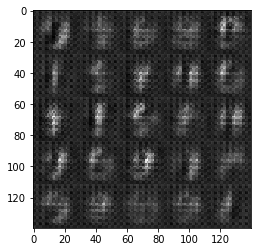

Epoch 1/2... Discriminator Loss: 2.6514... Generator Loss: 0.2129
Epoch 1/2... Discriminator Loss: 0.7427... Generator Loss: 1.4883
Epoch 1/2... Discriminator Loss: 0.6677... Generator Loss: 1.8372
Epoch 1/2... Discriminator Loss: 1.2248... Generator Loss: 3.3734
Epoch 1/2... Discriminator Loss: 0.8685... Generator Loss: 1.0958
Epoch 1/2... Discriminator Loss: 0.8489... Generator Loss: 1.2785
Epoch 1/2... Discriminator Loss: 0.8501... Generator Loss: 1.2426
Epoch 1/2... Discriminator Loss: 1.0346... Generator Loss: 0.9700
Epoch 1/2... Discriminator Loss: 1.2973... Generator Loss: 2.0943
Epoch 1/2... Discriminator Loss: 0.8848... Generator Loss: 2.2391


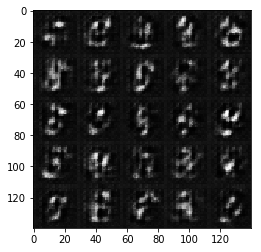

Epoch 1/2... Discriminator Loss: 1.3826... Generator Loss: 0.5365
Epoch 1/2... Discriminator Loss: 1.1276... Generator Loss: 1.6060
Epoch 1/2... Discriminator Loss: 0.8588... Generator Loss: 1.5210
Epoch 1/2... Discriminator Loss: 0.8349... Generator Loss: 1.9049
Epoch 1/2... Discriminator Loss: 1.5648... Generator Loss: 0.4281
Epoch 1/2... Discriminator Loss: 1.3178... Generator Loss: 2.0270
Epoch 1/2... Discriminator Loss: 1.3551... Generator Loss: 2.8672
Epoch 1/2... Discriminator Loss: 0.9236... Generator Loss: 1.7343
Epoch 1/2... Discriminator Loss: 0.9855... Generator Loss: 0.8860
Epoch 1/2... Discriminator Loss: 0.8203... Generator Loss: 1.2967


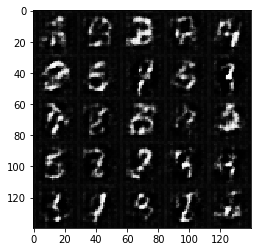

Epoch 1/2... Discriminator Loss: 0.9358... Generator Loss: 1.0203
Epoch 1/2... Discriminator Loss: 0.7996... Generator Loss: 1.6724
Epoch 1/2... Discriminator Loss: 1.0433... Generator Loss: 0.7920
Epoch 1/2... Discriminator Loss: 0.9246... Generator Loss: 1.0056
Epoch 1/2... Discriminator Loss: 1.3772... Generator Loss: 2.9492
Epoch 1/2... Discriminator Loss: 0.7332... Generator Loss: 1.6910
Epoch 1/2... Discriminator Loss: 1.4794... Generator Loss: 4.1466
Epoch 1/2... Discriminator Loss: 0.9758... Generator Loss: 0.9224
Epoch 1/2... Discriminator Loss: 1.4250... Generator Loss: 3.9561
Epoch 1/2... Discriminator Loss: 0.9506... Generator Loss: 1.2657


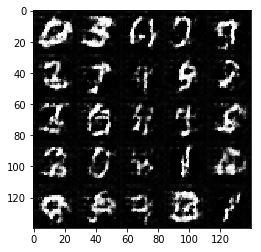

Epoch 1/2... Discriminator Loss: 1.3476... Generator Loss: 0.5454
Epoch 1/2... Discriminator Loss: 0.9101... Generator Loss: 1.6014
Epoch 1/2... Discriminator Loss: 0.8479... Generator Loss: 1.1568
Epoch 1/2... Discriminator Loss: 1.1186... Generator Loss: 0.6979
Epoch 1/2... Discriminator Loss: 0.8808... Generator Loss: 1.1615
Epoch 1/2... Discriminator Loss: 0.8591... Generator Loss: 2.3592
Epoch 1/2... Discriminator Loss: 0.8526... Generator Loss: 1.2983
Epoch 1/2... Discriminator Loss: 0.8622... Generator Loss: 1.1045
Epoch 1/2... Discriminator Loss: 1.0604... Generator Loss: 2.7336
Epoch 1/2... Discriminator Loss: 1.1614... Generator Loss: 0.7033


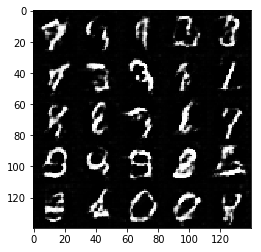

Epoch 1/2... Discriminator Loss: 0.9460... Generator Loss: 2.1650
Epoch 1/2... Discriminator Loss: 1.1636... Generator Loss: 0.8195
Epoch 1/2... Discriminator Loss: 0.8673... Generator Loss: 1.6342
Epoch 1/2... Discriminator Loss: 1.2918... Generator Loss: 0.5847
Epoch 1/2... Discriminator Loss: 1.1542... Generator Loss: 0.7030
Epoch 1/2... Discriminator Loss: 0.9954... Generator Loss: 0.9013
Epoch 1/2... Discriminator Loss: 0.9331... Generator Loss: 1.0195
Epoch 1/2... Discriminator Loss: 1.0029... Generator Loss: 0.8698
Epoch 1/2... Discriminator Loss: 1.1265... Generator Loss: 0.7909
Epoch 1/2... Discriminator Loss: 0.8976... Generator Loss: 1.1905


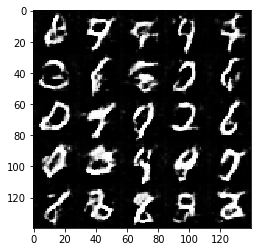

Epoch 1/2... Discriminator Loss: 0.9544... Generator Loss: 1.9740
Epoch 1/2... Discriminator Loss: 0.7964... Generator Loss: 1.3906
Epoch 1/2... Discriminator Loss: 1.0385... Generator Loss: 0.8424
Epoch 1/2... Discriminator Loss: 1.1662... Generator Loss: 0.6913
Epoch 1/2... Discriminator Loss: 0.8629... Generator Loss: 1.7042
Epoch 1/2... Discriminator Loss: 1.4308... Generator Loss: 0.4966
Epoch 1/2... Discriminator Loss: 1.2410... Generator Loss: 0.7558
Epoch 1/2... Discriminator Loss: 0.8015... Generator Loss: 1.4769
Epoch 1/2... Discriminator Loss: 0.9111... Generator Loss: 1.0369
Epoch 1/2... Discriminator Loss: 1.0046... Generator Loss: 0.8709


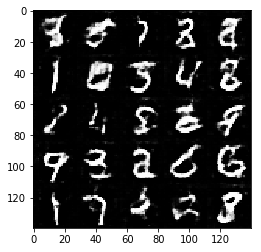

Epoch 1/2... Discriminator Loss: 1.1354... Generator Loss: 0.7621
Epoch 1/2... Discriminator Loss: 1.2110... Generator Loss: 0.6341
Epoch 1/2... Discriminator Loss: 1.2318... Generator Loss: 0.7166
Epoch 1/2... Discriminator Loss: 0.8636... Generator Loss: 1.2141
Epoch 1/2... Discriminator Loss: 0.9285... Generator Loss: 1.0191
Epoch 1/2... Discriminator Loss: 0.9750... Generator Loss: 2.4099
Epoch 1/2... Discriminator Loss: 0.9864... Generator Loss: 0.8919
Epoch 1/2... Discriminator Loss: 0.9184... Generator Loss: 2.0144
Epoch 1/2... Discriminator Loss: 1.2922... Generator Loss: 0.6340
Epoch 1/2... Discriminator Loss: 1.7266... Generator Loss: 0.3518


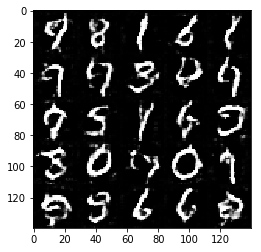

Epoch 1/2... Discriminator Loss: 1.1582... Generator Loss: 2.7375
Epoch 1/2... Discriminator Loss: 0.8600... Generator Loss: 1.0776
Epoch 1/2... Discriminator Loss: 0.7422... Generator Loss: 1.5583
Epoch 1/2... Discriminator Loss: 1.0860... Generator Loss: 0.8042
Epoch 1/2... Discriminator Loss: 1.1263... Generator Loss: 1.7709
Epoch 1/2... Discriminator Loss: 0.9891... Generator Loss: 1.3524
Epoch 1/2... Discriminator Loss: 1.8377... Generator Loss: 0.3759
Epoch 1/2... Discriminator Loss: 1.0682... Generator Loss: 0.8178
Epoch 1/2... Discriminator Loss: 1.0281... Generator Loss: 1.8133
Epoch 1/2... Discriminator Loss: 1.2895... Generator Loss: 0.5742


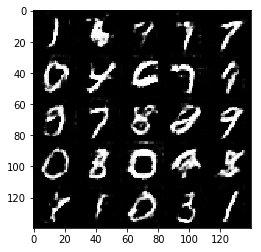

Epoch 1/2... Discriminator Loss: 1.1291... Generator Loss: 1.9110
Epoch 1/2... Discriminator Loss: 0.9775... Generator Loss: 2.0650
Epoch 1/2... Discriminator Loss: 0.7783... Generator Loss: 1.2408
Epoch 2/2... Discriminator Loss: 1.1304... Generator Loss: 0.9007
Epoch 2/2... Discriminator Loss: 1.3274... Generator Loss: 0.5856
Epoch 2/2... Discriminator Loss: 0.8883... Generator Loss: 1.5526
Epoch 2/2... Discriminator Loss: 0.9176... Generator Loss: 1.0804
Epoch 2/2... Discriminator Loss: 0.8175... Generator Loss: 1.3631
Epoch 2/2... Discriminator Loss: 1.1737... Generator Loss: 0.6879
Epoch 2/2... Discriminator Loss: 1.6824... Generator Loss: 0.4181


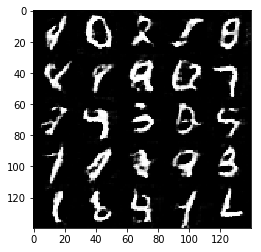

Epoch 2/2... Discriminator Loss: 0.7472... Generator Loss: 1.5424
Epoch 2/2... Discriminator Loss: 1.7080... Generator Loss: 0.4193
Epoch 2/2... Discriminator Loss: 0.7272... Generator Loss: 1.6881
Epoch 2/2... Discriminator Loss: 0.9780... Generator Loss: 1.5124
Epoch 2/2... Discriminator Loss: 1.3345... Generator Loss: 0.5943
Epoch 2/2... Discriminator Loss: 0.9099... Generator Loss: 1.2176
Epoch 2/2... Discriminator Loss: 1.1854... Generator Loss: 2.6256
Epoch 2/2... Discriminator Loss: 0.8998... Generator Loss: 1.0259
Epoch 2/2... Discriminator Loss: 1.3756... Generator Loss: 0.5320
Epoch 2/2... Discriminator Loss: 2.2861... Generator Loss: 0.2245


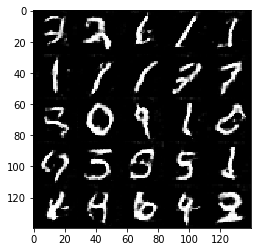

Epoch 2/2... Discriminator Loss: 1.2234... Generator Loss: 0.6277
Epoch 2/2... Discriminator Loss: 1.3027... Generator Loss: 0.5641
Epoch 2/2... Discriminator Loss: 1.8167... Generator Loss: 0.3362
Epoch 2/2... Discriminator Loss: 0.9354... Generator Loss: 1.2494
Epoch 2/2... Discriminator Loss: 0.8467... Generator Loss: 1.5349
Epoch 2/2... Discriminator Loss: 1.2032... Generator Loss: 2.5064
Epoch 2/2... Discriminator Loss: 0.9212... Generator Loss: 1.0008
Epoch 2/2... Discriminator Loss: 1.0428... Generator Loss: 0.8915
Epoch 2/2... Discriminator Loss: 1.7650... Generator Loss: 0.3524
Epoch 2/2... Discriminator Loss: 1.2156... Generator Loss: 0.6336


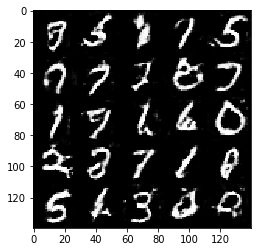

Epoch 2/2... Discriminator Loss: 0.7548... Generator Loss: 1.5123
Epoch 2/2... Discriminator Loss: 1.1164... Generator Loss: 0.8013
Epoch 2/2... Discriminator Loss: 3.0970... Generator Loss: 4.9964
Epoch 2/2... Discriminator Loss: 0.9467... Generator Loss: 0.9858
Epoch 2/2... Discriminator Loss: 0.8042... Generator Loss: 1.5651
Epoch 2/2... Discriminator Loss: 0.8247... Generator Loss: 1.2078
Epoch 2/2... Discriminator Loss: 0.8052... Generator Loss: 1.5264
Epoch 2/2... Discriminator Loss: 1.2258... Generator Loss: 0.6564
Epoch 2/2... Discriminator Loss: 2.3133... Generator Loss: 0.2271
Epoch 2/2... Discriminator Loss: 0.8865... Generator Loss: 1.0824


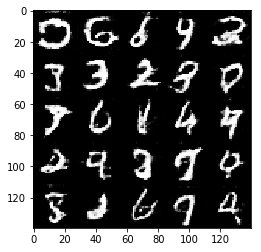

Epoch 2/2... Discriminator Loss: 1.0361... Generator Loss: 2.4285
Epoch 2/2... Discriminator Loss: 0.8187... Generator Loss: 1.5542
Epoch 2/2... Discriminator Loss: 0.8935... Generator Loss: 1.1858
Epoch 2/2... Discriminator Loss: 0.8355... Generator Loss: 1.3241
Epoch 2/2... Discriminator Loss: 1.4971... Generator Loss: 0.6716
Epoch 2/2... Discriminator Loss: 0.8867... Generator Loss: 1.1040
Epoch 2/2... Discriminator Loss: 0.8850... Generator Loss: 1.1603
Epoch 2/2... Discriminator Loss: 0.8721... Generator Loss: 1.4134
Epoch 2/2... Discriminator Loss: 0.9434... Generator Loss: 1.0816
Epoch 2/2... Discriminator Loss: 1.2770... Generator Loss: 2.4576


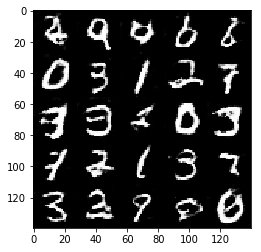

Epoch 2/2... Discriminator Loss: 0.7160... Generator Loss: 1.5686
Epoch 2/2... Discriminator Loss: 0.8738... Generator Loss: 1.0562
Epoch 2/2... Discriminator Loss: 0.7406... Generator Loss: 1.6516
Epoch 2/2... Discriminator Loss: 1.4899... Generator Loss: 0.5550
Epoch 2/2... Discriminator Loss: 0.9350... Generator Loss: 1.1358
Epoch 2/2... Discriminator Loss: 1.0936... Generator Loss: 0.8683
Epoch 2/2... Discriminator Loss: 1.1592... Generator Loss: 0.7397
Epoch 2/2... Discriminator Loss: 0.8523... Generator Loss: 1.2020
Epoch 2/2... Discriminator Loss: 1.8728... Generator Loss: 3.3458
Epoch 2/2... Discriminator Loss: 0.9218... Generator Loss: 1.2268


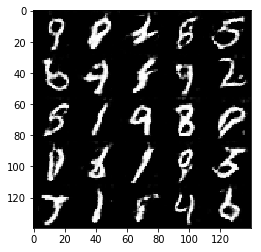

Epoch 2/2... Discriminator Loss: 1.2755... Generator Loss: 0.6275
Epoch 2/2... Discriminator Loss: 0.9994... Generator Loss: 0.9140
Epoch 2/2... Discriminator Loss: 1.1449... Generator Loss: 0.7509
Epoch 2/2... Discriminator Loss: 1.6003... Generator Loss: 0.4699
Epoch 2/2... Discriminator Loss: 0.7636... Generator Loss: 1.2833
Epoch 2/2... Discriminator Loss: 1.0581... Generator Loss: 0.8002
Epoch 2/2... Discriminator Loss: 0.8871... Generator Loss: 1.0956
Epoch 2/2... Discriminator Loss: 0.8346... Generator Loss: 1.2262
Epoch 2/2... Discriminator Loss: 1.1175... Generator Loss: 2.9552
Epoch 2/2... Discriminator Loss: 1.3451... Generator Loss: 3.2077


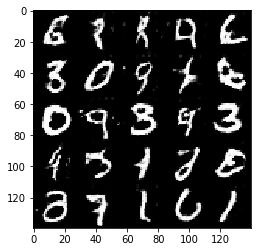

Epoch 2/2... Discriminator Loss: 1.0113... Generator Loss: 1.9174
Epoch 2/2... Discriminator Loss: 0.9935... Generator Loss: 1.1094
Epoch 2/2... Discriminator Loss: 0.6262... Generator Loss: 1.7018
Epoch 2/2... Discriminator Loss: 0.6622... Generator Loss: 2.1699
Epoch 2/2... Discriminator Loss: 1.0390... Generator Loss: 0.8731
Epoch 2/2... Discriminator Loss: 0.7443... Generator Loss: 1.4147
Epoch 2/2... Discriminator Loss: 1.2581... Generator Loss: 0.6315
Epoch 2/2... Discriminator Loss: 1.4324... Generator Loss: 3.3288
Epoch 2/2... Discriminator Loss: 1.4116... Generator Loss: 0.6164
Epoch 2/2... Discriminator Loss: 0.8709... Generator Loss: 1.0650


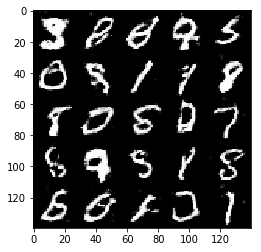

Epoch 2/2... Discriminator Loss: 1.0192... Generator Loss: 0.9028
Epoch 2/2... Discriminator Loss: 1.1867... Generator Loss: 0.7073
Epoch 2/2... Discriminator Loss: 1.4128... Generator Loss: 0.5420
Epoch 2/2... Discriminator Loss: 0.7839... Generator Loss: 1.3084
Epoch 2/2... Discriminator Loss: 0.8555... Generator Loss: 1.2661
Epoch 2/2... Discriminator Loss: 0.7449... Generator Loss: 1.8601
Epoch 2/2... Discriminator Loss: 1.9375... Generator Loss: 0.4584
Epoch 2/2... Discriminator Loss: 0.8607... Generator Loss: 1.8255
Epoch 2/2... Discriminator Loss: 1.3603... Generator Loss: 0.6449
Epoch 2/2... Discriminator Loss: 1.6375... Generator Loss: 3.1094


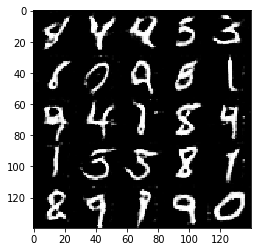

Epoch 2/2... Discriminator Loss: 0.7517... Generator Loss: 1.9253
Epoch 2/2... Discriminator Loss: 1.0111... Generator Loss: 0.8747
Epoch 2/2... Discriminator Loss: 0.9508... Generator Loss: 1.0330
Epoch 2/2... Discriminator Loss: 0.8693... Generator Loss: 1.0960
Epoch 2/2... Discriminator Loss: 0.7283... Generator Loss: 1.3919
Epoch 2/2... Discriminator Loss: 1.5990... Generator Loss: 0.4763
Epoch 2/2... Discriminator Loss: 1.0716... Generator Loss: 0.8606


In [29]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 10.2232... Generator Loss: 0.0002
Epoch 1/1... Discriminator Loss: 4.9063... Generator Loss: 0.0135
Epoch 1/1... Discriminator Loss: 0.7554... Generator Loss: 3.0096
Epoch 1/1... Discriminator Loss: 0.9152... Generator Loss: 3.9847
Epoch 1/1... Discriminator Loss: 0.6080... Generator Loss: 2.3041
Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 1.2147
Epoch 1/1... Discriminator Loss: 2.4404... Generator Loss: 3.7275
Epoch 1/1... Discriminator Loss: 1.2999... Generator Loss: 0.5424
Epoch 1/1... Discriminator Loss: 2.2846... Generator Loss: 3.4900
Epoch 1/1... Discriminator Loss: 0.9607... Generator Loss: 2.2401


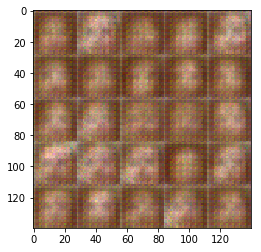

Epoch 1/1... Discriminator Loss: 1.0404... Generator Loss: 1.2615
Epoch 1/1... Discriminator Loss: 1.1406... Generator Loss: 1.0202
Epoch 1/1... Discriminator Loss: 1.3014... Generator Loss: 1.1322
Epoch 1/1... Discriminator Loss: 1.3257... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.6150
Epoch 1/1... Discriminator Loss: 2.6561... Generator Loss: 0.1167
Epoch 1/1... Discriminator Loss: 1.9268... Generator Loss: 0.2771
Epoch 1/1... Discriminator Loss: 1.3319... Generator Loss: 0.7461
Epoch 1/1... Discriminator Loss: 1.2794... Generator Loss: 0.8629
Epoch 1/1... Discriminator Loss: 1.9487... Generator Loss: 1.8018


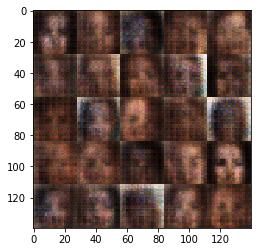

Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 1.9561
Epoch 1/1... Discriminator Loss: 1.0768... Generator Loss: 1.1386
Epoch 1/1... Discriminator Loss: 1.3074... Generator Loss: 0.7821
Epoch 1/1... Discriminator Loss: 1.2243... Generator Loss: 0.5920
Epoch 1/1... Discriminator Loss: 1.1843... Generator Loss: 1.0136
Epoch 1/1... Discriminator Loss: 1.8857... Generator Loss: 0.2779
Epoch 1/1... Discriminator Loss: 1.1878... Generator Loss: 0.8373
Epoch 1/1... Discriminator Loss: 1.2683... Generator Loss: 0.5773
Epoch 1/1... Discriminator Loss: 1.3450... Generator Loss: 0.6600
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 1.6766


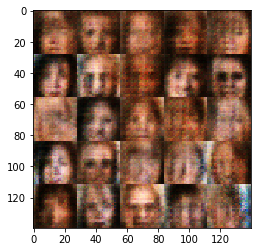

Epoch 1/1... Discriminator Loss: 1.5416... Generator Loss: 0.4079
Epoch 1/1... Discriminator Loss: 1.5799... Generator Loss: 0.3994
Epoch 1/1... Discriminator Loss: 1.5318... Generator Loss: 0.4493
Epoch 1/1... Discriminator Loss: 1.2193... Generator Loss: 0.9410
Epoch 1/1... Discriminator Loss: 1.4646... Generator Loss: 0.8669
Epoch 1/1... Discriminator Loss: 1.3020... Generator Loss: 1.2751
Epoch 1/1... Discriminator Loss: 1.2762... Generator Loss: 0.8072
Epoch 1/1... Discriminator Loss: 1.1959... Generator Loss: 0.9554
Epoch 1/1... Discriminator Loss: 1.1933... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 1.4828... Generator Loss: 1.4206


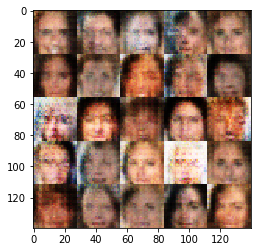

Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 1.5519
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.4766
Epoch 1/1... Discriminator Loss: 2.1777... Generator Loss: 0.1898
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 1.1838
Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 0.6070
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.5559
Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 0.7782
Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.8805
Epoch 1/1... Discriminator Loss: 1.2544... Generator Loss: 0.9775


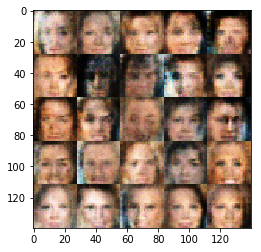

Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 1.1958
Epoch 1/1... Discriminator Loss: 1.2283... Generator Loss: 0.9698
Epoch 1/1... Discriminator Loss: 1.2518... Generator Loss: 0.8908
Epoch 1/1... Discriminator Loss: 1.2892... Generator Loss: 1.1988
Epoch 1/1... Discriminator Loss: 1.3310... Generator Loss: 0.9444
Epoch 1/1... Discriminator Loss: 1.3344... Generator Loss: 1.1479
Epoch 1/1... Discriminator Loss: 1.3415... Generator Loss: 0.6824
Epoch 1/1... Discriminator Loss: 2.1017... Generator Loss: 0.2180
Epoch 1/1... Discriminator Loss: 1.2101... Generator Loss: 1.0038
Epoch 1/1... Discriminator Loss: 1.2255... Generator Loss: 0.8167


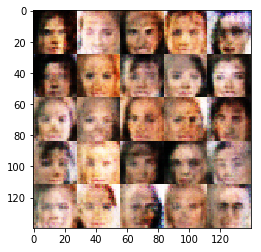

Epoch 1/1... Discriminator Loss: 1.5030... Generator Loss: 1.2670
Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 0.8608
Epoch 1/1... Discriminator Loss: 1.1704... Generator Loss: 0.6644
Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.8727
Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 0.8638
Epoch 1/1... Discriminator Loss: 1.3067... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 1.1246... Generator Loss: 0.9283
Epoch 1/1... Discriminator Loss: 1.1861... Generator Loss: 0.9286
Epoch 1/1... Discriminator Loss: 1.1511... Generator Loss: 0.8167
Epoch 1/1... Discriminator Loss: 2.2691... Generator Loss: 3.3009


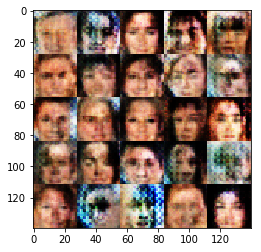

Epoch 1/1... Discriminator Loss: 0.9379... Generator Loss: 2.1507
Epoch 1/1... Discriminator Loss: 0.9012... Generator Loss: 2.5137
Epoch 1/1... Discriminator Loss: 0.8713... Generator Loss: 1.8810
Epoch 1/1... Discriminator Loss: 1.2963... Generator Loss: 2.0763
Epoch 1/1... Discriminator Loss: 1.2722... Generator Loss: 0.5726
Epoch 1/1... Discriminator Loss: 1.1126... Generator Loss: 1.0986
Epoch 1/1... Discriminator Loss: 0.6647... Generator Loss: 2.7868
Epoch 1/1... Discriminator Loss: 0.7073... Generator Loss: 2.0126
Epoch 1/1... Discriminator Loss: 1.8146... Generator Loss: 0.2929
Epoch 1/1... Discriminator Loss: 1.3494... Generator Loss: 0.5523


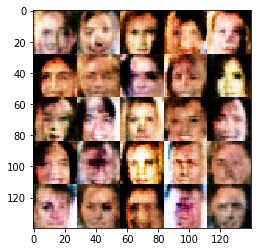

Epoch 1/1... Discriminator Loss: 0.9857... Generator Loss: 2.7915
Epoch 1/1... Discriminator Loss: 1.4989... Generator Loss: 1.9112
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.5019
Epoch 1/1... Discriminator Loss: 1.4686... Generator Loss: 0.8203
Epoch 1/1... Discriminator Loss: 1.2481... Generator Loss: 1.3453
Epoch 1/1... Discriminator Loss: 1.1475... Generator Loss: 0.8838
Epoch 1/1... Discriminator Loss: 1.0434... Generator Loss: 1.1436
Epoch 1/1... Discriminator Loss: 1.2563... Generator Loss: 0.5688
Epoch 1/1... Discriminator Loss: 1.3118... Generator Loss: 0.5428
Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.4750


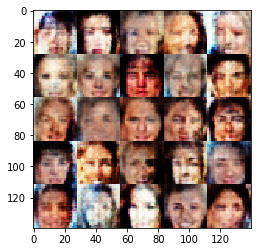

Epoch 1/1... Discriminator Loss: 0.4502... Generator Loss: 3.8979
Epoch 1/1... Discriminator Loss: 1.3014... Generator Loss: 1.2585
Epoch 1/1... Discriminator Loss: 1.2639... Generator Loss: 2.3372
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.4634
Epoch 1/1... Discriminator Loss: 1.8236... Generator Loss: 0.2842
Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 1.0469
Epoch 1/1... Discriminator Loss: 1.0811... Generator Loss: 0.9446
Epoch 1/1... Discriminator Loss: 1.2235... Generator Loss: 1.0227
Epoch 1/1... Discriminator Loss: 2.4608... Generator Loss: 2.7678
Epoch 1/1... Discriminator Loss: 0.5732... Generator Loss: 1.6969


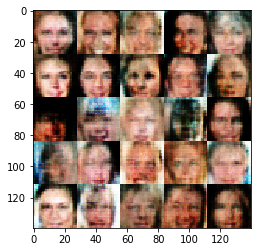

Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 0.5604
Epoch 1/1... Discriminator Loss: 0.4800... Generator Loss: 2.7619
Epoch 1/1... Discriminator Loss: 0.3932... Generator Loss: 3.3446
Epoch 1/1... Discriminator Loss: 3.9439... Generator Loss: 5.2627
Epoch 1/1... Discriminator Loss: 0.7336... Generator Loss: 1.1776
Epoch 1/1... Discriminator Loss: 1.5752... Generator Loss: 3.9966
Epoch 1/1... Discriminator Loss: 0.9888... Generator Loss: 3.4620
Epoch 1/1... Discriminator Loss: 0.9539... Generator Loss: 0.8136
Epoch 1/1... Discriminator Loss: 1.6904... Generator Loss: 5.0183
Epoch 1/1... Discriminator Loss: 0.4376... Generator Loss: 2.4964


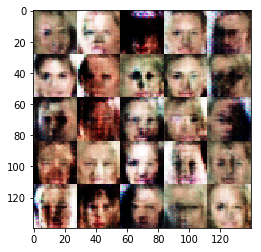

Epoch 1/1... Discriminator Loss: 1.1402... Generator Loss: 0.6240
Epoch 1/1... Discriminator Loss: 0.5961... Generator Loss: 2.0207
Epoch 1/1... Discriminator Loss: 0.8529... Generator Loss: 3.1892
Epoch 1/1... Discriminator Loss: 1.6676... Generator Loss: 1.8413
Epoch 1/1... Discriminator Loss: 1.7186... Generator Loss: 0.3257
Epoch 1/1... Discriminator Loss: 1.3027... Generator Loss: 0.5318
Epoch 1/1... Discriminator Loss: 0.7404... Generator Loss: 1.1567
Epoch 1/1... Discriminator Loss: 0.4167... Generator Loss: 2.8737
Epoch 1/1... Discriminator Loss: 0.3599... Generator Loss: 4.4824
Epoch 1/1... Discriminator Loss: 0.4659... Generator Loss: 2.2226


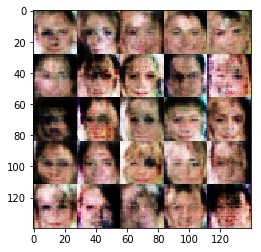

Epoch 1/1... Discriminator Loss: 0.4624... Generator Loss: 2.2673
Epoch 1/1... Discriminator Loss: 0.3564... Generator Loss: 4.3612
Epoch 1/1... Discriminator Loss: 1.5233... Generator Loss: 0.4330
Epoch 1/1... Discriminator Loss: 0.4245... Generator Loss: 2.8663
Epoch 1/1... Discriminator Loss: 0.3857... Generator Loss: 3.3744
Epoch 1/1... Discriminator Loss: 0.3731... Generator Loss: 3.5080
Epoch 1/1... Discriminator Loss: 2.0738... Generator Loss: 0.2293
Epoch 1/1... Discriminator Loss: 1.1804... Generator Loss: 0.9132
Epoch 1/1... Discriminator Loss: 1.0694... Generator Loss: 1.9106
Epoch 1/1... Discriminator Loss: 0.5750... Generator Loss: 2.5099


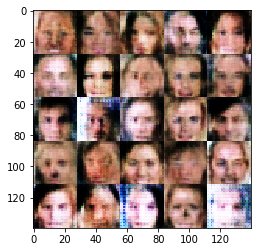

Epoch 1/1... Discriminator Loss: 0.3954... Generator Loss: 3.0662
Epoch 1/1... Discriminator Loss: 0.7135... Generator Loss: 1.9951
Epoch 1/1... Discriminator Loss: 0.3805... Generator Loss: 3.7696
Epoch 1/1... Discriminator Loss: 0.3651... Generator Loss: 3.8158
Epoch 1/1... Discriminator Loss: 1.8409... Generator Loss: 0.2997
Epoch 1/1... Discriminator Loss: 0.4905... Generator Loss: 2.0571
Epoch 1/1... Discriminator Loss: 1.6177... Generator Loss: 0.4469
Epoch 1/1... Discriminator Loss: 0.3716... Generator Loss: 4.0119
Epoch 1/1... Discriminator Loss: 1.2548... Generator Loss: 0.7441
Epoch 1/1... Discriminator Loss: 1.1428... Generator Loss: 0.8324


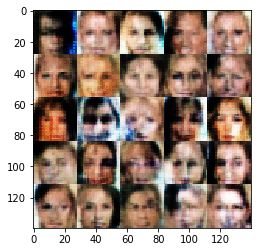

Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 4.3829
Epoch 1/1... Discriminator Loss: 1.4934... Generator Loss: 0.4370
Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 0.5455
Epoch 1/1... Discriminator Loss: 1.1235... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 0.4505... Generator Loss: 4.7800
Epoch 1/1... Discriminator Loss: 1.3429... Generator Loss: 0.4955
Epoch 1/1... Discriminator Loss: 1.2168... Generator Loss: 0.6193
Epoch 1/1... Discriminator Loss: 0.8339... Generator Loss: 0.9820
Epoch 1/1... Discriminator Loss: 0.3902... Generator Loss: 5.2785
Epoch 1/1... Discriminator Loss: 1.9297... Generator Loss: 0.2645


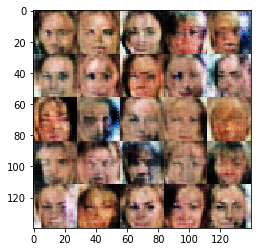

Epoch 1/1... Discriminator Loss: 0.6174... Generator Loss: 1.6371
Epoch 1/1... Discriminator Loss: 0.3421... Generator Loss: 5.1627
Epoch 1/1... Discriminator Loss: 0.4429... Generator Loss: 5.4241
Epoch 1/1... Discriminator Loss: 1.1955... Generator Loss: 7.2415
Epoch 1/1... Discriminator Loss: 0.4400... Generator Loss: 2.4806
Epoch 1/1... Discriminator Loss: 2.0635... Generator Loss: 0.2934
Epoch 1/1... Discriminator Loss: 1.1470... Generator Loss: 1.0016
Epoch 1/1... Discriminator Loss: 0.8140... Generator Loss: 1.0891
Epoch 1/1... Discriminator Loss: 1.4739... Generator Loss: 0.4390
Epoch 1/1... Discriminator Loss: 0.7445... Generator Loss: 1.2558


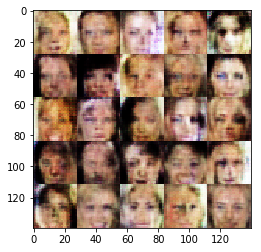

Epoch 1/1... Discriminator Loss: 0.3909... Generator Loss: 3.1825
Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 1.2958
Epoch 1/1... Discriminator Loss: 1.1422... Generator Loss: 1.6232
Epoch 1/1... Discriminator Loss: 0.5155... Generator Loss: 3.2618
Epoch 1/1... Discriminator Loss: 1.0873... Generator Loss: 1.3975
Epoch 1/1... Discriminator Loss: 0.5253... Generator Loss: 1.9709
Epoch 1/1... Discriminator Loss: 1.3247... Generator Loss: 4.6156
Epoch 1/1... Discriminator Loss: 0.8185... Generator Loss: 1.0704
Epoch 1/1... Discriminator Loss: 0.4616... Generator Loss: 3.4151
Epoch 1/1... Discriminator Loss: 0.4390... Generator Loss: 2.5518


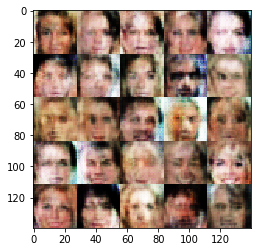

Epoch 1/1... Discriminator Loss: 0.8787... Generator Loss: 0.9877
Epoch 1/1... Discriminator Loss: 0.3885... Generator Loss: 3.8365
Epoch 1/1... Discriminator Loss: 0.4677... Generator Loss: 3.0216
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 6.2156
Epoch 1/1... Discriminator Loss: 0.6215... Generator Loss: 2.1339
Epoch 1/1... Discriminator Loss: 0.5162... Generator Loss: 2.0822
Epoch 1/1... Discriminator Loss: 1.0202... Generator Loss: 6.3141
Epoch 1/1... Discriminator Loss: 0.5797... Generator Loss: 1.6184
Epoch 1/1... Discriminator Loss: 0.3977... Generator Loss: 3.1028
Epoch 1/1... Discriminator Loss: 0.4541... Generator Loss: 2.3937


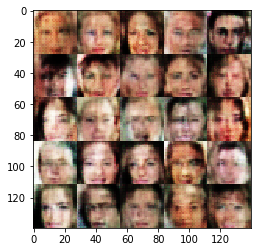

Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 0.6022
Epoch 1/1... Discriminator Loss: 1.0763... Generator Loss: 0.7279
Epoch 1/1... Discriminator Loss: 1.6853... Generator Loss: 0.4022
Epoch 1/1... Discriminator Loss: 0.4385... Generator Loss: 2.5665
Epoch 1/1... Discriminator Loss: 0.4027... Generator Loss: 4.3058
Epoch 1/1... Discriminator Loss: 0.9839... Generator Loss: 4.2796
Epoch 1/1... Discriminator Loss: 0.4541... Generator Loss: 3.0046
Epoch 1/1... Discriminator Loss: 0.5074... Generator Loss: 3.1198
Epoch 1/1... Discriminator Loss: 0.5094... Generator Loss: 1.9745
Epoch 1/1... Discriminator Loss: 0.5004... Generator Loss: 4.6296


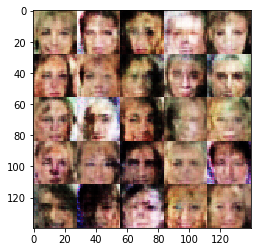

Epoch 1/1... Discriminator Loss: 0.7433... Generator Loss: 1.2659
Epoch 1/1... Discriminator Loss: 2.6626... Generator Loss: 4.9460
Epoch 1/1... Discriminator Loss: 0.4086... Generator Loss: 3.1669
Epoch 1/1... Discriminator Loss: 0.4438... Generator Loss: 2.6386
Epoch 1/1... Discriminator Loss: 0.9379... Generator Loss: 1.4806
Epoch 1/1... Discriminator Loss: 0.5404... Generator Loss: 1.9634
Epoch 1/1... Discriminator Loss: 0.4456... Generator Loss: 4.7557
Epoch 1/1... Discriminator Loss: 0.7038... Generator Loss: 1.3509
Epoch 1/1... Discriminator Loss: 0.6542... Generator Loss: 4.1104
Epoch 1/1... Discriminator Loss: 0.7254... Generator Loss: 1.2204


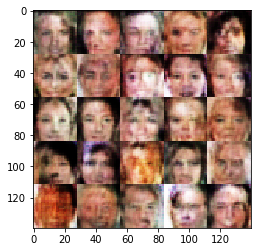

Epoch 1/1... Discriminator Loss: 1.4630... Generator Loss: 0.4861
Epoch 1/1... Discriminator Loss: 0.9999... Generator Loss: 0.8129
Epoch 1/1... Discriminator Loss: 0.3963... Generator Loss: 3.2120
Epoch 1/1... Discriminator Loss: 0.7288... Generator Loss: 2.9757
Epoch 1/1... Discriminator Loss: 0.6074... Generator Loss: 1.5894
Epoch 1/1... Discriminator Loss: 0.4500... Generator Loss: 4.0176
Epoch 1/1... Discriminator Loss: 0.5528... Generator Loss: 1.8517
Epoch 1/1... Discriminator Loss: 2.7757... Generator Loss: 4.2662
Epoch 1/1... Discriminator Loss: 0.4215... Generator Loss: 4.6705
Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 4.2234


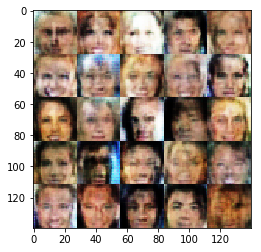

Epoch 1/1... Discriminator Loss: 0.6756... Generator Loss: 1.4512
Epoch 1/1... Discriminator Loss: 0.6281... Generator Loss: 1.4950
Epoch 1/1... Discriminator Loss: 0.3942... Generator Loss: 3.2334
Epoch 1/1... Discriminator Loss: 0.7910... Generator Loss: 1.2266
Epoch 1/1... Discriminator Loss: 1.1767... Generator Loss: 4.5924
Epoch 1/1... Discriminator Loss: 0.3754... Generator Loss: 5.2318
Epoch 1/1... Discriminator Loss: 0.4272... Generator Loss: 2.7041
Epoch 1/1... Discriminator Loss: 0.3828... Generator Loss: 5.3762
Epoch 1/1... Discriminator Loss: 0.3634... Generator Loss: 3.8433
Epoch 1/1... Discriminator Loss: 0.5424... Generator Loss: 5.1658


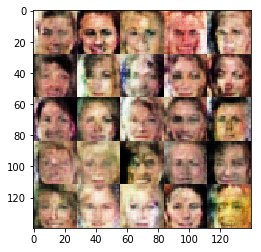

Epoch 1/1... Discriminator Loss: 0.3582... Generator Loss: 4.4337
Epoch 1/1... Discriminator Loss: 1.1543... Generator Loss: 0.6715
Epoch 1/1... Discriminator Loss: 0.4377... Generator Loss: 4.4101
Epoch 1/1... Discriminator Loss: 0.4532... Generator Loss: 2.3993
Epoch 1/1... Discriminator Loss: 0.5746... Generator Loss: 2.5030
Epoch 1/1... Discriminator Loss: 0.4628... Generator Loss: 2.3509
Epoch 1/1... Discriminator Loss: 0.6534... Generator Loss: 6.3601
Epoch 1/1... Discriminator Loss: 0.3876... Generator Loss: 5.4723
Epoch 1/1... Discriminator Loss: 0.5595... Generator Loss: 5.8234
Epoch 1/1... Discriminator Loss: 0.3525... Generator Loss: 5.3162


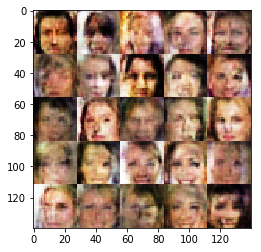

Epoch 1/1... Discriminator Loss: 0.9983... Generator Loss: 0.8230
Epoch 1/1... Discriminator Loss: 0.3837... Generator Loss: 3.3876
Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 1.3271
Epoch 1/1... Discriminator Loss: 0.5997... Generator Loss: 1.7904
Epoch 1/1... Discriminator Loss: 0.5034... Generator Loss: 2.8459
Epoch 1/1... Discriminator Loss: 0.4325... Generator Loss: 3.9187
Epoch 1/1... Discriminator Loss: 1.8583... Generator Loss: 5.8359
Epoch 1/1... Discriminator Loss: 0.5958... Generator Loss: 2.8854
Epoch 1/1... Discriminator Loss: 0.5224... Generator Loss: 1.9641
Epoch 1/1... Discriminator Loss: 0.5427... Generator Loss: 1.8753


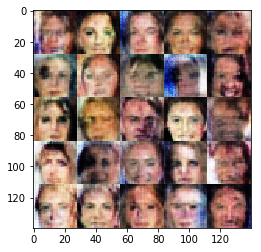

Epoch 1/1... Discriminator Loss: 0.6189... Generator Loss: 1.7661
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 5.2006
Epoch 1/1... Discriminator Loss: 0.5795... Generator Loss: 1.9084
Epoch 1/1... Discriminator Loss: 0.9540... Generator Loss: 1.2839
Epoch 1/1... Discriminator Loss: 0.5030... Generator Loss: 3.6923
Epoch 1/1... Discriminator Loss: 0.4363... Generator Loss: 4.3106
Epoch 1/1... Discriminator Loss: 0.6816... Generator Loss: 1.4269
Epoch 1/1... Discriminator Loss: 0.6366... Generator Loss: 4.2833
Epoch 1/1... Discriminator Loss: 0.4106... Generator Loss: 3.3040
Epoch 1/1... Discriminator Loss: 0.4804... Generator Loss: 2.2721


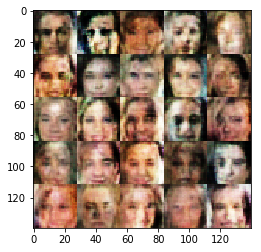

Epoch 1/1... Discriminator Loss: 0.4027... Generator Loss: 3.3417
Epoch 1/1... Discriminator Loss: 0.3618... Generator Loss: 5.8482
Epoch 1/1... Discriminator Loss: 0.4750... Generator Loss: 2.3176
Epoch 1/1... Discriminator Loss: 1.4755... Generator Loss: 0.5573
Epoch 1/1... Discriminator Loss: 0.4284... Generator Loss: 3.4514
Epoch 1/1... Discriminator Loss: 0.4191... Generator Loss: 2.7472
Epoch 1/1... Discriminator Loss: 0.8354... Generator Loss: 1.1142
Epoch 1/1... Discriminator Loss: 0.5813... Generator Loss: 1.8304
Epoch 1/1... Discriminator Loss: 0.4050... Generator Loss: 5.0828
Epoch 1/1... Discriminator Loss: 0.5399... Generator Loss: 1.8983


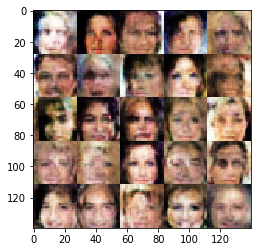

Epoch 1/1... Discriminator Loss: 1.3440... Generator Loss: 0.5469
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.5028
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 3.7508
Epoch 1/1... Discriminator Loss: 0.5281... Generator Loss: 1.9481
Epoch 1/1... Discriminator Loss: 0.7996... Generator Loss: 1.2071
Epoch 1/1... Discriminator Loss: 0.5181... Generator Loss: 5.0501
Epoch 1/1... Discriminator Loss: 0.3749... Generator Loss: 4.5634
Epoch 1/1... Discriminator Loss: 0.7313... Generator Loss: 5.6088
Epoch 1/1... Discriminator Loss: 1.2185... Generator Loss: 7.0513
Epoch 1/1... Discriminator Loss: 0.5681... Generator Loss: 1.6861


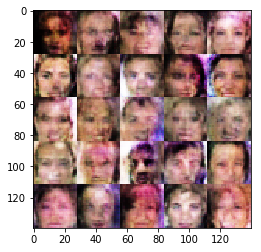

Epoch 1/1... Discriminator Loss: 0.5220... Generator Loss: 2.0753
Epoch 1/1... Discriminator Loss: 0.4341... Generator Loss: 5.8423
Epoch 1/1... Discriminator Loss: 0.4997... Generator Loss: 2.3008
Epoch 1/1... Discriminator Loss: 0.5356... Generator Loss: 2.3259
Epoch 1/1... Discriminator Loss: 0.6093... Generator Loss: 1.7011
Epoch 1/1... Discriminator Loss: 1.0218... Generator Loss: 0.8349
Epoch 1/1... Discriminator Loss: 0.9919... Generator Loss: 0.9615
Epoch 1/1... Discriminator Loss: 0.4510... Generator Loss: 2.6710
Epoch 1/1... Discriminator Loss: 0.9881... Generator Loss: 5.1695
Epoch 1/1... Discriminator Loss: 0.4507... Generator Loss: 2.4933


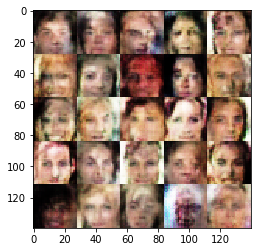

Epoch 1/1... Discriminator Loss: 0.3669... Generator Loss: 3.8501
Epoch 1/1... Discriminator Loss: 0.7520... Generator Loss: 1.2627
Epoch 1/1... Discriminator Loss: 0.6868... Generator Loss: 3.4071
Epoch 1/1... Discriminator Loss: 0.4398... Generator Loss: 2.5640
Epoch 1/1... Discriminator Loss: 1.1680... Generator Loss: 0.8647
Epoch 1/1... Discriminator Loss: 0.4752... Generator Loss: 3.1672
Epoch 1/1... Discriminator Loss: 0.6112... Generator Loss: 1.6465
Epoch 1/1... Discriminator Loss: 0.4438... Generator Loss: 3.1759
Epoch 1/1... Discriminator Loss: 0.6894... Generator Loss: 1.3789
Epoch 1/1... Discriminator Loss: 0.4080... Generator Loss: 3.9743


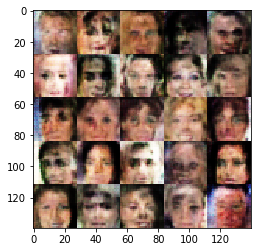

Epoch 1/1... Discriminator Loss: 0.3504... Generator Loss: 5.0126
Epoch 1/1... Discriminator Loss: 0.3805... Generator Loss: 3.5259
Epoch 1/1... Discriminator Loss: 0.4025... Generator Loss: 3.0604
Epoch 1/1... Discriminator Loss: 0.3734... Generator Loss: 5.7869
Epoch 1/1... Discriminator Loss: 0.3682... Generator Loss: 3.7315
Epoch 1/1... Discriminator Loss: 0.4382... Generator Loss: 2.9912
Epoch 1/1... Discriminator Loss: 0.4029... Generator Loss: 4.5403
Epoch 1/1... Discriminator Loss: 0.8384... Generator Loss: 1.1413
Epoch 1/1... Discriminator Loss: 0.4819... Generator Loss: 5.0484
Epoch 1/1... Discriminator Loss: 0.6291... Generator Loss: 1.5645


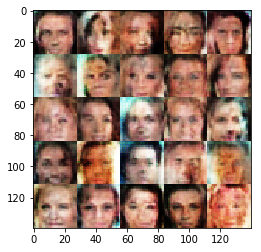

Epoch 1/1... Discriminator Loss: 0.4812... Generator Loss: 2.8627
Epoch 1/1... Discriminator Loss: 0.3738... Generator Loss: 3.9901
Epoch 1/1... Discriminator Loss: 0.5320... Generator Loss: 2.0548
Epoch 1/1... Discriminator Loss: 0.9924... Generator Loss: 5.6861
Epoch 1/1... Discriminator Loss: 3.0495... Generator Loss: 4.1502
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.5454
Epoch 1/1... Discriminator Loss: 0.3983... Generator Loss: 3.5066
Epoch 1/1... Discriminator Loss: 0.3953... Generator Loss: 3.0801
Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 5.6935
Epoch 1/1... Discriminator Loss: 0.6232... Generator Loss: 1.6119


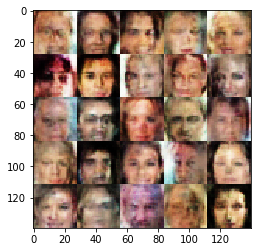

Epoch 1/1... Discriminator Loss: 0.3953... Generator Loss: 3.6586
Epoch 1/1... Discriminator Loss: 0.4352... Generator Loss: 4.3561
Epoch 1/1... Discriminator Loss: 0.4486... Generator Loss: 2.5028


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.